
# 🌍 Analyzing Sea Level Rise Using Earth Data in the Cloud

### This notebook is entirely based on Jinbo Wang's [tutorial](https://github.com/betolink/the-coding-club/blob/main/notebooks/Earthdata_webinar_20220727.ipynb)

<img src="https://www.nasa.gov/sites/default/files/styles/full_width/public/thumbnails/image/sealevel_main-causes3-16.jpg?itok=XAqGqps1" width="800px" />

--- 

**We are going to reproduce the plot from this infographic** Source: [ NASA-led Study Reveals the Causes of Sea Level Rise Since 1900 ](https://grace.jpl.nasa.gov/news/113/nasa-led-study-reveals-the-causes-of-sea-level-rise-since-1900/)


In [2]:
import earthaccess

if earthaccess.__version__!="0.5.3":
    print("Installing the latest version of earthaccess, please restart the kernel after this cell gets executed")
    !pip install earthaccess==0.5.3
else:
    print("Using the latest version of earthaccess")
    pass

Using the latest version of earthaccess


In [3]:
print(f"using earthaccess v{earthaccess.__version__}")

auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

using earthaccess v0.5.3
EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/27/2023
Using .netrc file for EDL


### Why earthaccess?

earthaccess is a Python library that simplifies data discovery and access to NASA Earth science data by providing an abstraction layer for NASA’s Common Metadata Repository (CMR) Search API so that searching for data can be done using a simpler notation instead of low level HTTP queries. 

## Authentication in the cloud

If the collection is a cloud-hosted collection we can print the `summary()` and get the S3 credential endpoint. These S3 credentials are temporary and we can use them with third party libraries such as s3fs, boto3 or awscli.

In [4]:
from pprint import pprint
# We'll get 4 collections that match with our keywords
collections = earthaccess.collection_query().keyword("SEA SURFACE HEIGHT").cloud_hosted(True).get(4)

# Let's print 2 collections
for collection in collections[0:2]:
    # pprint(collection.summary())
    print(pprint(collection.summary()), collection.abstract(), "\n", collection["umm"]["DOI"], "\n\n")

{'cloud-info': {'Region': 'us-west-2',
                'S3BucketAndObjectPrefixNames': ['podaac-ops-cumulus-public/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205/',
                                                 'podaac-ops-cumulus-protected/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205/'],
                'S3CredentialsAPIDocumentationURL': 'https://archive.podaac.earthdata.nasa.gov/s3credentialsREADME',
                'S3CredentialsAPIEndpoint': 'https://archive.podaac.earthdata.nasa.gov/s3credentials'},
 'concept-id': 'C2270392799-POCLOUD',
 'file-type': "[{'Format': 'netCDF-4', 'FormatType': 'Native', "
              "'AverageFileSize': 9.7, 'AverageFileSizeUnit': 'MB'}]",
 'get-data': ['https://cmr.earthdata.nasa.gov/virtual-directory/collections/C2270392799-POCLOUD',
              'https://search.earthdata.nasa.gov/search/granules?p=C2270392799-POCLOUD'],
 'short-name': 'SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205',
 'version': '2205'

## A year of data 

Things to keep in mind:

* this particular dataset has data until 2019
* this is a global dataset, each granule represents the whole world
* temporal coverage is 1 granule each 5 days

In [8]:
granules = earthaccess.granule_query().short_name("SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205").temporal("2017-01","2018-01").cloud_hosted(True).get(10)

print(f"Items retrieved: {len(results)}")

Items retrieved: 10


## Using earthaccess top level methods.

earthaccess can query for datasets or data on a particular dataset, it can also use python objects to concatenate the query paramters or we can use a top level function.

**Important**: So far we are only working with metadata records from NASA CMR, the results we get are just json objects with information about how and where to get the actual data files.

In [9]:
# This is equivalent to the method above.

results = earthaccess.search_data(
    short_name='SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205',
    cloud_hosted=True,
    temporal=("2017-01", "2018-01"),
    count=10
)
print(f"Items retrieved: {len(results)}")

Granules found: 73
Items retrieved: 10


## Working with the URLs directly

If we chose, we can use `earthdata` to grab the file's URLs and then download them with another library (if we have a `.netrc` file configured with NASA's EDL credentials)
Getting the links to our data is quiet simple with the `data_links()` method on each of the results:

In [10]:
# the collection is cloud hosted, but we can access it out of AWS with the regular HTTPS URL
granules[0].data_links(access="out_of_region")

['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205/ssh_grids_v2205_2017010212.nc']

In [11]:
granules[0].data_links(access="direct")

['s3://podaac-ops-cumulus-protected/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205/ssh_grids_v2205_2017010212.nc']

## POC: streaming into xarray

We can use `earthaccess` to stream files directly into xarray, this will work well for cases where:

* Data is in NetCDF/HDF5/Zaar format
  * xarray can read bytes directly for remote datasets only with **`h5netcdf`** and **`scipy`** back-ends, if we deal with a format that won't be recognized by these 2 backends xarray will raise an exception.
* Data is not big data (multi TB)
  * not fully tested with Dask distributed
* Data is gridded
  * xarray works better with homogeneous coordinates, working with swath data will be cumbersome.
* Data is chunked using reasonable large sizes(1MB or more)
  * If our files are chunked in small pieces the access time will be orders of magnitude bigger than just downloading the data and accessing it locally.
  
Opening a year of SSH (SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812) data (1.1 GB approx) can take up to 5 minutes streaming the data out of region(not in AWS)
The reason for this is not that the data transfer is order of magintude slower but due the client libraries not fetching data concurrently and the metadata of the files in HDF is usually not consolidated like in Zaar, hence h5netcdf has to issue a lot of requests to get the info it needs.

> Note: we are looping through each year and getting the metadata for the first granule in May

In [12]:
#  storing the resulting granule metadata
granules = []

# we just grab 1 granule from May for each year of the dataset
for year in range(1999, 2019):
    print(f"Retrieving data for year: {year}")
    results = earthaccess.search_data(
        doi = "10.5067/SLREF-CDRV3",
        temporal=(f"{year}-05", f"{year}-06")
    )
    if len(results)>0:
        granules.append(results[0])
print(f"Total granules: {len(granules)}")

Retrieving data for year: 1999
Granules found: 7
Retrieving data for year: 2000
Granules found: 7
Retrieving data for year: 2001
Granules found: 7
Retrieving data for year: 2002
Granules found: 7
Retrieving data for year: 2003
Granules found: 7
Retrieving data for year: 2004
Granules found: 6
Retrieving data for year: 2005
Granules found: 6
Retrieving data for year: 2006
Granules found: 6
Retrieving data for year: 2007
Granules found: 6
Retrieving data for year: 2008
Granules found: 6
Retrieving data for year: 2009
Granules found: 6
Retrieving data for year: 2010
Granules found: 6
Retrieving data for year: 2011
Granules found: 6
Retrieving data for year: 2012
Granules found: 6
Retrieving data for year: 2013
Granules found: 6
Retrieving data for year: 2014
Granules found: 6
Retrieving data for year: 2015
Granules found: 6
Retrieving data for year: 2016
Granules found: 7
Retrieving data for year: 2017
Granules found: 7
Retrieving data for year: 2018
Granules found: 7
Total granules: 20


### What `earthaccess.open()` do?

`earthaccess.open()` takes a list of results from `earthaccess.search_data()` or a list of URLs and creates a list of Python File-like objects that can be used in our code as if the remote files were local. When executed in AWS the file system used is [S3FS](https://github.com/fsspec/s3fs) when we open files outside of AWS we get a regular HTTPS file session. 


In [13]:
%%time

import xarray as xr

fileset = earthaccess.open(granules)

ds = xr.open_mfdataset(fileset, chunks={})
ds

 Opening 20 granules, approx size: 0.18 GB


SUBMITTING | : 0it [00:00, ?it/s]

PROCESSING | :   0%|          | 0/20 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 4.84 s, sys: 1.02 s, total: 5.86 s
Wall time: 23.2 s


<xarray.Dataset>
Dimensions:      (Time: 20, Longitude: 2160, nv: 2, Latitude: 960)
Coordinates:
  * Longitude    (Longitude) float32 0.08333 0.25 0.4167 ... 359.6 359.8 359.9
  * Latitude     (Latitude) float32 -79.92 -79.75 -79.58 ... 79.58 79.75 79.92
  * Time         (Time) datetime64[ns] 1999-05-02T12:00:00 ... 2018-05-02T12:...
Dimensions without coordinates: nv
Data variables:
    Lon_bounds   (Time, Longitude, nv) float32 dask.array<chunksize=(1, 2160, 2), meta=np.ndarray>
    Lat_bounds   (Time, Latitude, nv) float32 dask.array<chunksize=(1, 960, 2), meta=np.ndarray>
    Time_bounds  (Time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    SLA          (Time, Latitude, Longitude) float32 dask.array<chunksize=(1, 960, 2160), meta=np.ndarray>
    SLA_ERR      (Time, Latitude, Longitude) float32 dask.array<chunksize=(1, 960, 2160), meta=np.ndarray>
Attributes: (12/21)
    Conventions:            CF-1.6
    ncei_template_version:  NCEI_NetCDF_Grid_Template_v2.0
    Institution:            Jet Propulsion Laboratory
    geospatial_lat_min:     -79.916664
    geospatial_lat_max:     79.916664
    geospatial_lon_min:     0.083333336
    ...                     ...
    version_number:         2205
    Data_Pnts_Each_Sat:     {"16": 764589, "1002": 637661}
    source_version:         commit 7ba4d2404171bab4068e03a666a335c7a44c5f09
    SLA_Global_MEAN:        -0.012298334728518514
    SLA_Global_STD:         0.09172898644796465
    latency:                final

## Plotting 

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


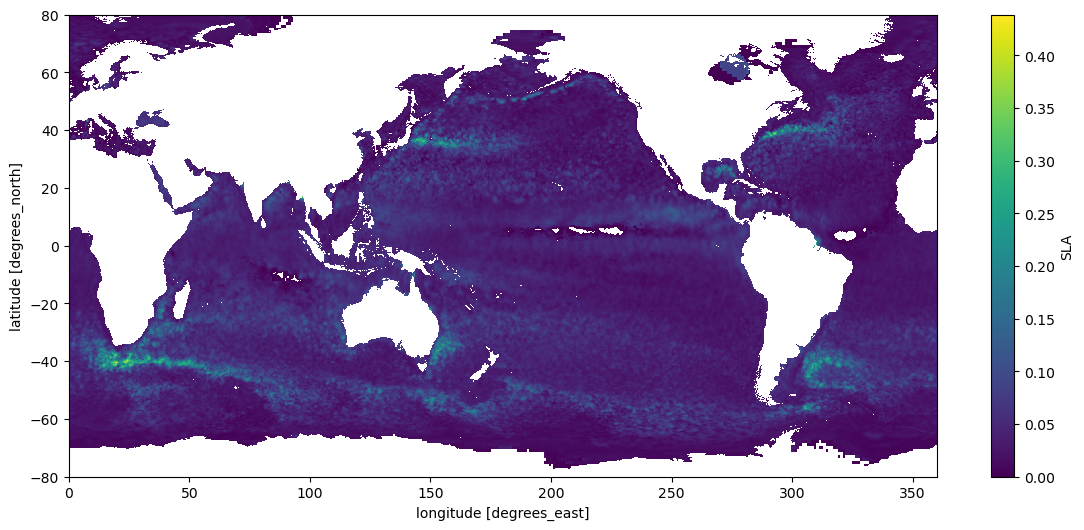

In [14]:
ds.SLA.where((ds.SLA>=0) & (ds.SLA < 10)).std('Time').plot(figsize=(14,6), x='Longitude', y='Latitude')

In [15]:
from pyproj import Geod
import numpy as np

def ssl_area(lats):
    """
    Calculate the area associated with a 1/6 by 1/6 degree box at latitude specified in 'lats'.
    
    Parameter
    ==========
    lats: a list or numpy array of size N the latitudes of interest. 
    
    Return
    =======
    out: Array (N) area values (unit: m^2)
    """
    # Define WGS84 as CRS:
    geod = Geod(ellps='WGS84')
    dx=1/12.0
    # TODO: explain this
    c_area=lambda lat: geod.polygon_area_perimeter(np.r_[-dx,dx,dx,-dx], lat+np.r_[-dx,-dx,dx,dx])[0]
    out=[]
    for lat in lats:
        out.append(c_area(lat))
    return np.array(out)
# note: they rotated the data in the last release, this operation used to be (1,-1)
ssh_area = ssl_area(ds.Latitude.data).reshape(-1,1)
print(ssh_area.shape)

(960, 1)


### Loading historic in-situ values from the [Reconstructed Global Mean Sea Level 1900-2018](https://cmr.earthdata.nasa.gov/search/collections.umm_json?concept_id=C2491724765-POCLOUD)

In [16]:
# This dataset was moved from opendap, contains the historic in situ data
granule = earthaccess.search_data(concept_id="C2491724765-POCLOUD")[0].data_links()[0]
gmsl = earthaccess.open([granule])[0]

Granules found: 1


SUBMITTING | : 0it [00:00, ?it/s]

PROCESSING | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/1 [00:00<?, ?it/s]

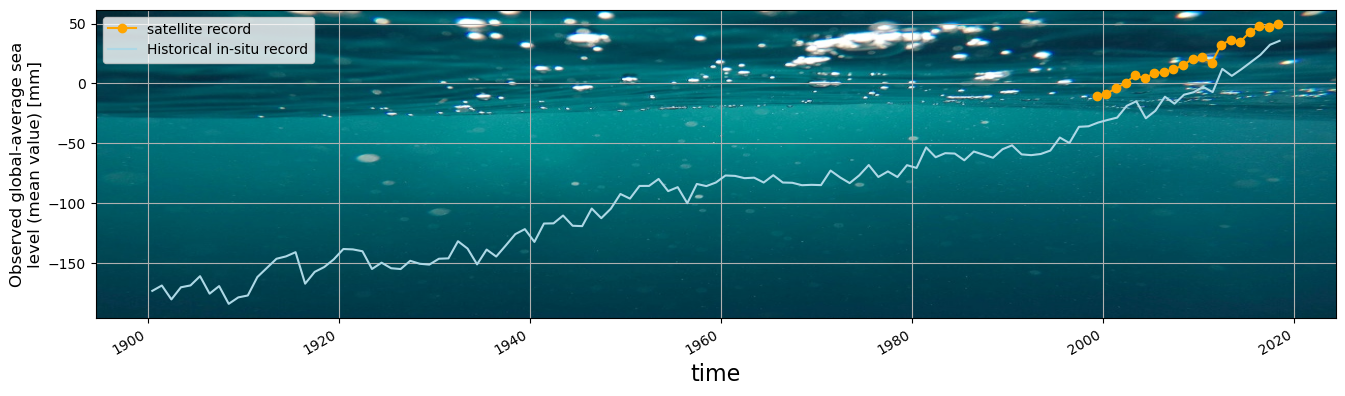

CPU times: user 2.6 s, sys: 118 ms, total: 2.72 s
Wall time: 3.67 s


In [17]:
%%time

import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (16,4)

img = plt.imread("underwater.jpg")

fig, axs = plt.subplots()
plt.grid(True)

def global_mean(SLA, **kwargs):
    dout=((SLA*ssh_area).sum()/(SLA/SLA*ssh_area).sum())*1000
    return dout

result = ds.SLA.groupby('Time').apply(global_mean)

plt.xlabel('Time (year)',fontsize=16)
plt.ylabel('Global Mean SLA (meter)',fontsize=12)
# axs.imshow(img, aspect='auto')
plt.grid(True)

historic_ts=xr.open_dataset(gmsl)

result.plot(ax=axs, color="orange", marker="o", label='satellite record')
historic_ts['global_average_sea_level_change'].plot(ax=axs, label='Historical in-situ record', color="lightblue")

x0,x1 = axs.get_xlim()
y0,y1 = axs.get_ylim()
axs.imshow(img, extent=[x0, x1, y0, y1], aspect='auto')

plt.legend()
plt.show()